In [1]:
from typing import Tuple, List, Union
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch import Tensor
import torch.nn as nn
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Resize

In [2]:
class Cifar10RotationData(Dataset):
    def __init__(self, train: bool):
        data = CIFAR10(root="../../data/cifar10", train=train, download=True).data
        self.len = len(data) * 4

        data0 = torch.tensor(data).permute([0, 3, 1, 2]).float()
        data90 = torch.rot90(data0, k=1, dims=(2, 3))
        data180 = torch.rot90(data0, k=2, dims=(2, 3))
        data270 = torch.rot90(data0, k=3, dims=(2, 3))
        self.data = torch.cat([data0, data90, data180, data270], dim=0)
        self.target = torch.cat([i * torch.ones(size=(len(data),)) for i in range(4)], dim=0).long()

    def __len__(self):
        return self.len

    def __getitem__(self, id: int):
        return self.data[id], self.target[id]


class EncoderBlock(nn.Module):
    def __init__(self, in_ch: int, out_ch: int, stride: int, use_rezero: bool):
        super().__init__()
        self.use_rezero = use_rezero
        self.rect = nn.LeakyReLU()

        # inner convolution
        self.conv_inner = nn.Conv2d(
            in_channels=in_ch,
            out_channels=out_ch,
            kernel_size=3,
            padding=1)
        self.bn_inner = nn.BatchNorm2d(num_features=out_ch)

        # inner skip connection
        self.coupler_skip = nn.Conv2d(
            in_channels=in_ch,
            out_channels=out_ch,
            kernel_size=1)
        self.bn_skip_inner = nn.BatchNorm2d(num_features=out_ch)

        # outer convolution
        self.conv_outer = nn.Conv2d(
            in_channels=out_ch,
            out_channels=out_ch,
            kernel_size=stride,
            stride=stride)
        self.bn_outer = nn.BatchNorm2d(num_features=out_ch)

        # outer skip connection
        self.pool = nn.AvgPool2d(kernel_size=stride)
        self.bn_skip_outer = nn.BatchNorm2d(num_features=out_ch)

        # rezero
        if self.use_rezero:
            self.rezero_inner = nn.Parameter(torch.tensor([0]).float())
            self.rezero_outer = nn.Parameter(torch.tensor([0]).float())

    def forward(self, x: Tensor) -> Tensor:
        if self.use_rezero:
            # inner convolution
            inner_non_lin = self.rect(self.bn_inner(self.conv_inner(x)))
            inner_lin = self.rect(self.bn_skip_inner(self.coupler_skip(x)))
            inner = self.rezero_inner * inner_non_lin + inner_lin  # inner residual

            # outer convolution
            outer_non_lin = self.rect(self.bn_outer(self.conv_outer(inner)))
            outer_lin = self.bn_skip_outer(self.pool(inner_non_lin))
            outer = self.rezero_outer * outer_non_lin + outer_lin  # outer residual
        else:
            # inner convolution
            inner_non_lin = self.rect(self.bn_inner(self.conv_inner(x)))
            inner_lin = self.rect(self.bn_skip_inner(self.coupler_skip(x)))
            inner = inner_non_lin + inner_lin  # inner residual

            # outer convolution
            outer_non_lin = self.rect(self.bn_outer(self.conv_outer(inner)))
            outer_lin = self.bn_skip_outer(self.pool(inner_non_lin))
            outer = outer_non_lin + outer_lin
        return outer


class ClassifierRot(nn.Module):
    def __init__(self, chs: Tuple[int, int, int], use_rezero: bool):
        super().__init__()
        self.stage1 = EncoderBlock(in_ch=3, out_ch=chs[0], stride=2, use_rezero=use_rezero)
        self.stage2 = EncoderBlock(in_ch=chs[0], out_ch=chs[1], stride=4, use_rezero=use_rezero)
        self.stage3 = EncoderBlock(in_ch=chs[1], out_ch=chs[2], stride=4, use_rezero=use_rezero)
        self.flatten = nn.Flatten()
        self.head = nn.Linear(in_features=chs[2], out_features=4)
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, x: Tensor, y: Tensor):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        scores = self.head(self.flatten(x))
        loss = self.ce_loss(scores, y)
        return {"loss": loss, "scores": scores}


class Classifier(nn.Module):
    def __init__(self, encoder: nn.Module, example_input: Tensor):
        super().__init__()
        self.encoder = encoder
        self.flatten = nn.Flatten(start_dim=1)
        self.linear = nn.Linear(
            in_features=self.find_n_lin_inputs(example_input=example_input),
            out_features=10)
        self.ce_loss = nn.CrossEntropyLoss()

    def find_n_lin_inputs(self, example_input: Tensor) -> int:
        encoding = self.encoder(example_input)
        return self.flatten(encoding).size(1)

    def forward(self, x: Tensor, y: Tensor):
        scores = self.linear(self.flatten(self.encoder(x)))
        loss = self.ce_loss(scores, y)
        return {"loss": loss, "scores": scores}


def top_k_accuracy(scores: Tensor, targets: Tensor, k: int) -> float:
    _, top_args = torch.topk(scores, k=k)
    return torch.sum(torch.any(top_args == targets.unsqueeze(1), dim=1)).item() / len(targets)


def train(
        module: nn.Module,
        loader: DataLoader,
        n_epochs: int,
        lr: float,
        device: str) -> Tuple[nn.Module, List[float]]:
    module.train()
    optimizer = torch.optim.Adam(params=module.parameters(), lr=lr)
    losses = []
    for epoch in range(n_epochs):
        for batch in loader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            loss = module(x=x, y=y)["loss"]
            loss_item = loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss_item)
    return module, losses


def eval(
        module: nn.Module,
        loader: DataLoader,
        device: str,
        calc_acc5: bool = True) -> Union[float, Tuple[float, float]]:
    module.eval()
    scores = []
    targets = []
    with torch.no_grad():
        for batch in loader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            out = module(x=x, y=y)
            scores.append(out["scores"].to("cpu"))
            targets.append(y)

    acc1 = top_k_accuracy(scores=torch.cat(scores).to("cpu"), targets=torch.cat(targets).to("cpu"), k=1)
    if calc_acc5:
        acc5 = top_k_accuracy(scores=torch.cat(scores).to("cpu"), targets=torch.cat(targets).to("cpu"), k=5)
        return acc1, acc5
    else:
        return acc1


def train_eval_downstream(
        classifier: Classifier,
        name: str,
        n_epochs: int,
        device: str,
        lr: float,
        loader_train: DataLoader,
        loader_test: DataLoader) -> float:
    classifier, losses = train(
        module=classifier,
        loader=loader_train,
        lr=lr,
        device=device,
        n_epochs=n_epochs)
    acc1_train, acc5_train = eval(module=classifier, loader=loader_train, device=device)
    acc1_test, acc5_test = eval(module=classifier, loader=loader_test, device=device)
    plt.clf()
    plt.plot(range(len(losses)), losses)
    plt.title(
        f"{name}\nfinal train top 1, 5 acc: {acc1_train},{acc5_train}\nfinal test top 1, 5 acc: {acc1_test},{acc5_test}")
    plt.xlabel("training iteration")
    plt.ylabel("training loss")
    plt.tight_layout()
    plt.savefig(monitoring_path + f"/{name}")
    torch.save(classifier, monitoring_path + f"/{name}.pkl")
    plt.show()
    return acc1_test

In [3]:
### setup ###
# hyperparameters
batch_size = 128
device = "cuda"
monitoring_path = "../../monitoring/rotation_pretraining"

n_epochs_rot = 30
lr_rot = 0.0005

n_epochs_fine = 30
lr_fine = 0.0005

Files already downloaded and verified
Files already downloaded and verified


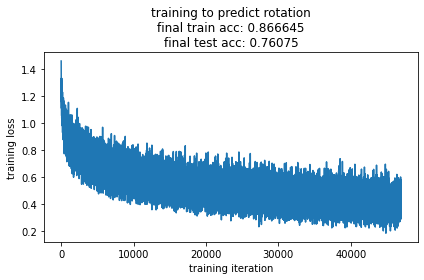

In [4]:
### rotation pretraining ###
classifier_rot = ClassifierRot(chs=(8, 16, 64), use_rezero=True).to(device)
torch.save(classifier_rot, monitoring_path + "/classifier_rot_initial.pkl")

# train data
data_train_rot = Cifar10RotationData(train=True)
loader_train_rot = DataLoader(
    dataset=data_train_rot,
    batch_size=batch_size,
    sampler=RandomSampler(data_source=data_train_rot))

# test data
data_test_rot = Cifar10RotationData(train=False)
loader_test_rot = DataLoader(
    dataset=data_test_rot,
    batch_size=batch_size,
    sampler=RandomSampler(data_source=data_test_rot))

classifier_rot, losses_rot = train(
    module=classifier_rot,
    loader=loader_train_rot,
    n_epochs=n_epochs_rot,
    lr=lr_rot,
    device=device)

rot_acc_train = eval(
    module=classifier_rot,
    loader=loader_train_rot,
    device=device,
    calc_acc5=False)
rot_acc_test = eval(
    module=classifier_rot,
    loader=loader_test_rot,
    device=device,
    calc_acc5=False)
plt.plot(range(len(losses_rot)), losses_rot)
plt.title(f"training to predict rotation\nfinal train acc: {rot_acc_train}\nfinal test acc: {rot_acc_test}")
plt.xlabel("training iteration")
plt.ylabel("training loss")
plt.tight_layout()
plt.savefig(monitoring_path + "/rot_train")
torch.save(classifier_rot, monitoring_path + "/classifier_rot.pkl")

Files already downloaded and verified
Files already downloaded and verified


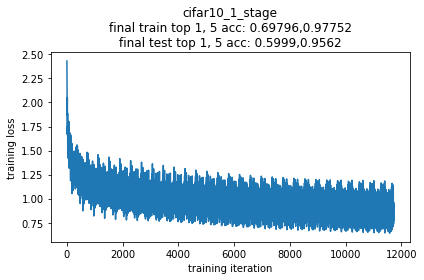

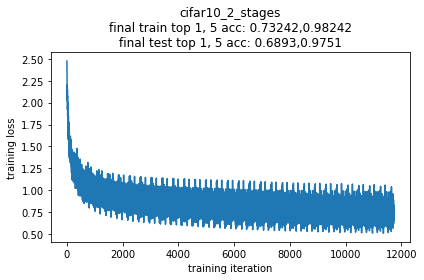

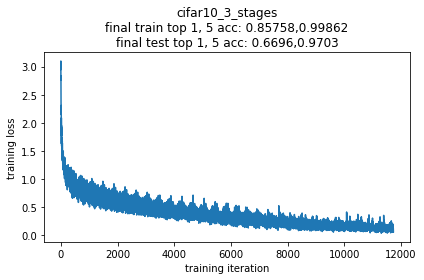

best number of stages: 2


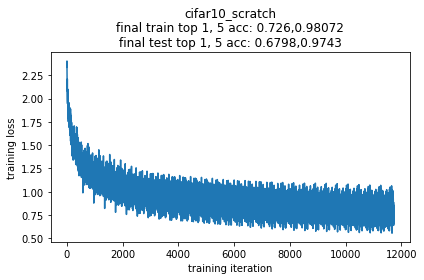

0.6798

In [5]:
###### fine tuning ######
classifier_rot = torch.load(monitoring_path + "/classifier_rot.pkl")
classifier_rot_initial = torch.load(monitoring_path + "/classifier_rot_initial.pkl")


### cifar10 fine tuning ###
cifar10_train = CIFAR10(root="../../data/cifar10", train=True, download=True, transform=ToTensor())
cifar10_loader_train = DataLoader(dataset=cifar10_train, batch_size=batch_size)
cifar10_test = CIFAR10(root="../../data/cifar10", train=False, download=True, transform=ToTensor())
cifar10_loader_test = DataLoader(dataset=cifar10_test, batch_size=batch_size)
example_input = next(iter(cifar10_loader_train))[0].to(device)

# one stage
encoder = classifier_rot.stage1
classifier = Classifier(encoder=encoder, example_input=example_input).to(device)
acc_1 = train_eval_downstream(
    classifier=classifier,
    name="cifar10_1_stage",
    loader_train=cifar10_loader_train,
    loader_test=cifar10_loader_test,
    lr=lr_fine,
    n_epochs=n_epochs_fine,
    device=device)

# two stages
encoder = nn.Sequential(classifier_rot.stage1, classifier_rot.stage2)
classifier = Classifier(encoder=encoder, example_input=example_input).to(device)
acc_2 = train_eval_downstream(
    classifier=classifier,
    name="cifar10_2_stages",
    loader_train=cifar10_loader_train,
    loader_test=cifar10_loader_test,
    lr=lr_fine,
    n_epochs=n_epochs_fine,
    device=device)

# three stages
encoder = nn.Sequential(classifier_rot.stage1, classifier_rot.stage2, classifier_rot.stage3)
classifier = Classifier(encoder=encoder, example_input=example_input).to(device)
acc_3 = train_eval_downstream(
    classifier=classifier,
    name="cifar10_3_stages",
    loader_train=cifar10_loader_train,
    loader_test=cifar10_loader_test,
    lr=lr_fine,
    n_epochs=n_epochs_fine,
    device=device)

# determine best number of stages based on the cifar10 results
best_n_stages = int(1 + torch.argmax(torch.tensor([acc_1, acc_2, acc_3])).item())
print("best number of stages:", best_n_stages)

# from scratch
if best_n_stages == 1:
    encoder = classifier_rot_initial.stage1
elif best_n_stages == 2:
    encoder = nn.Sequential(classifier_rot_initial.stage1, classifier_rot_initial.stage2)
else:
    encoder = nn.Sequential(classifier_rot_initial.stage1, classifier_rot_initial.stage2, classifier_rot_initial.stage3)
classifier = Classifier(encoder=encoder, example_input=example_input).to(device)
train_eval_downstream(
    classifier=classifier,
    name="cifar10_scratch",
    loader_train=cifar10_loader_train,
    loader_test=cifar10_loader_test,
    lr=lr_fine,
    n_epochs=n_epochs_fine,
    device=device)

# conclusions
- re-using two stages works best (third stage is probably not task-agnostic enough)
- fine tuning with two pretrained stages leads to better results than training two stages from scratch

tbd: repeat over 10 runs and average resulting scores